# Bitcoin Price. Prediction by ARIMA

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
import json
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Data Exploration

In [19]:
# Load data
df = pd.read_csv('/Users/rkankaria/Documents/CS784/arima/data.csv')
df.tail()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
3766758,1444311840,2015-10-08 13:44:00,BTC/USD,242.96,242.96,242.96,242.96,0.033491,8.137003
3766759,1444311780,2015-10-08 13:43:00,BTC/USD,242.95,242.96,242.95,242.96,0.010000,2.429600
3766760,1444311720,2015-10-08 13:42:00,BTC/USD,242.95,242.95,242.95,242.95,0.000000,0.000000
3766761,1444311660,2015-10-08 13:41:00,BTC/USD,242.50,242.95,242.50,242.95,0.001000,0.242950
3766762,1444311600,2015-10-08 13:40:00,BTC/USD,0.00,242.50,0.00,242.50,0.050000,12.125000


In [ ]:
consumer = KafkaConsumer(
        'feature_vector',
        bootstrap_servers=['localhost:9092'],
        auto_offset_reset='earliest',
        enable_auto_commit=True,
        group_id='my-group',
        value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    
print("Waiting for messages")
for msg in consumer:
    print(msg.value)

: 

In [22]:
# Unix-time to 
# df.Timestamp = pd.to_datetime(df.Timestamp, unit='ms')
# print(df.tail())

# Resampling to daily frequency
df.Date = pd.to_datetime(df.Date)
df.index = df.Date
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

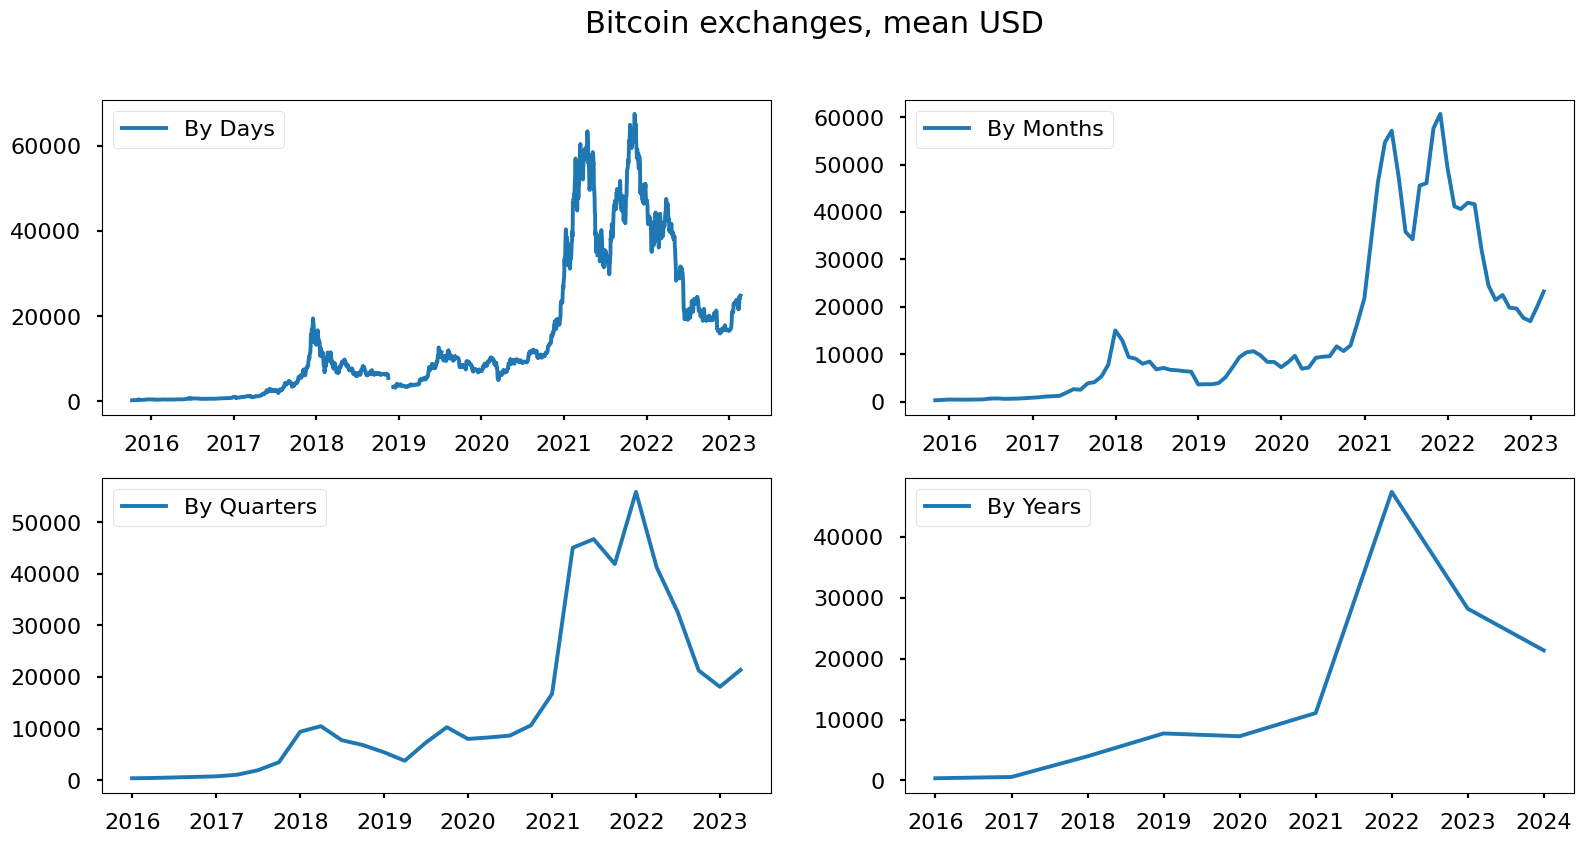

In [23]:
# PLOTS
fig = plt.figure(figsize=[19, 9])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.498168


<Figure size 1900x900 with 0 Axes>

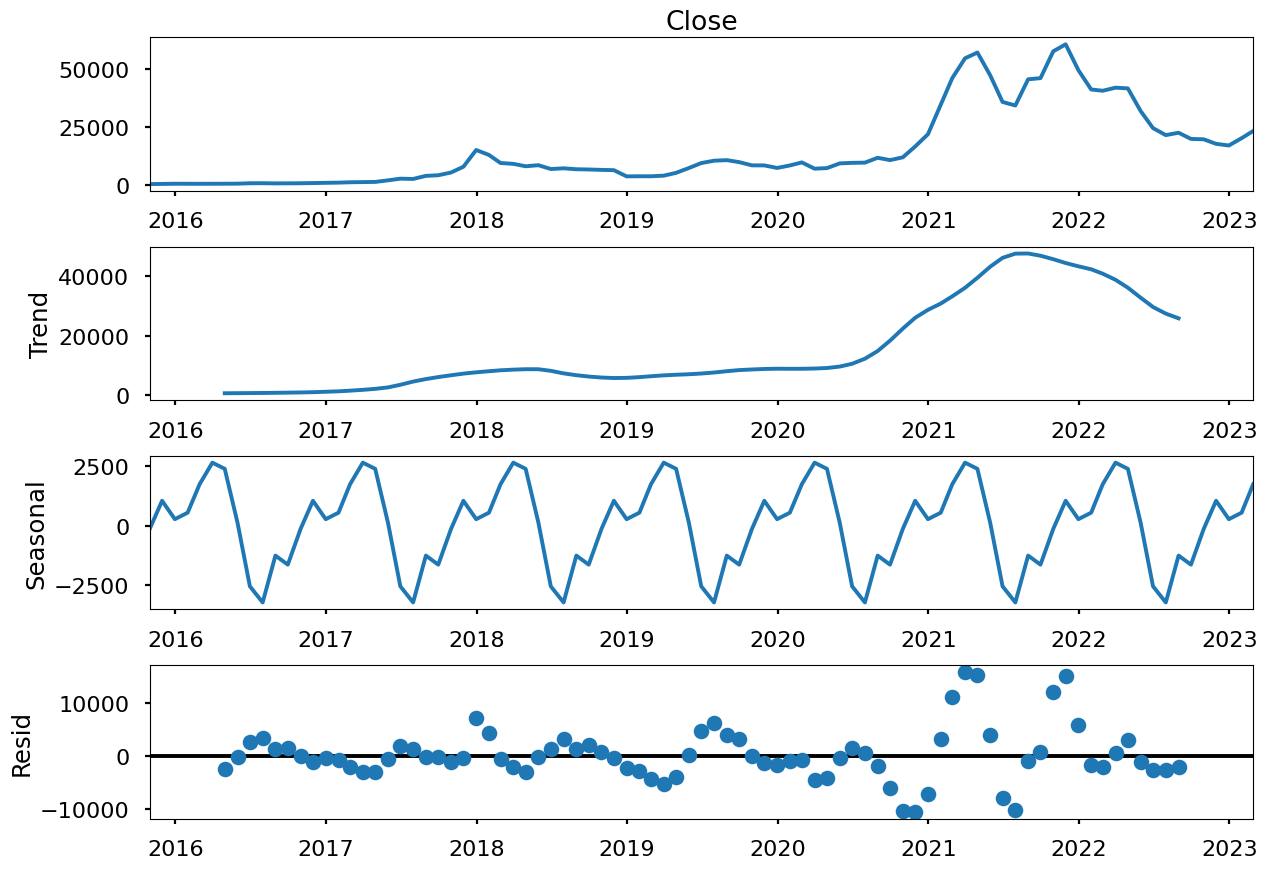

In [26]:
plt.figure(figsize=[19,9])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [27]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.498168


The series are not stationary.

## Seasonal differentiation

In [28]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.587413


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.000595


<Figure size 1900x900 with 0 Axes>

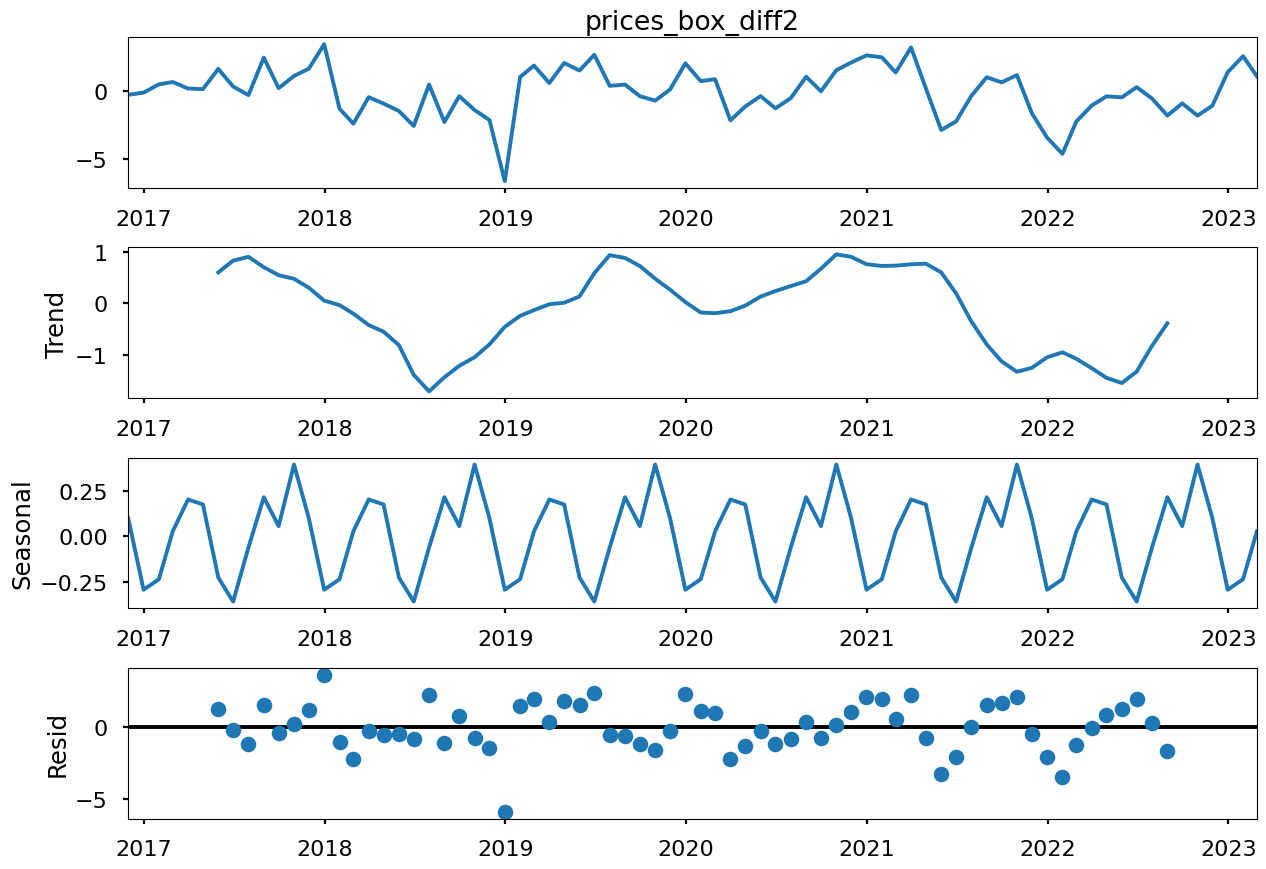

In [29]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(19,9))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

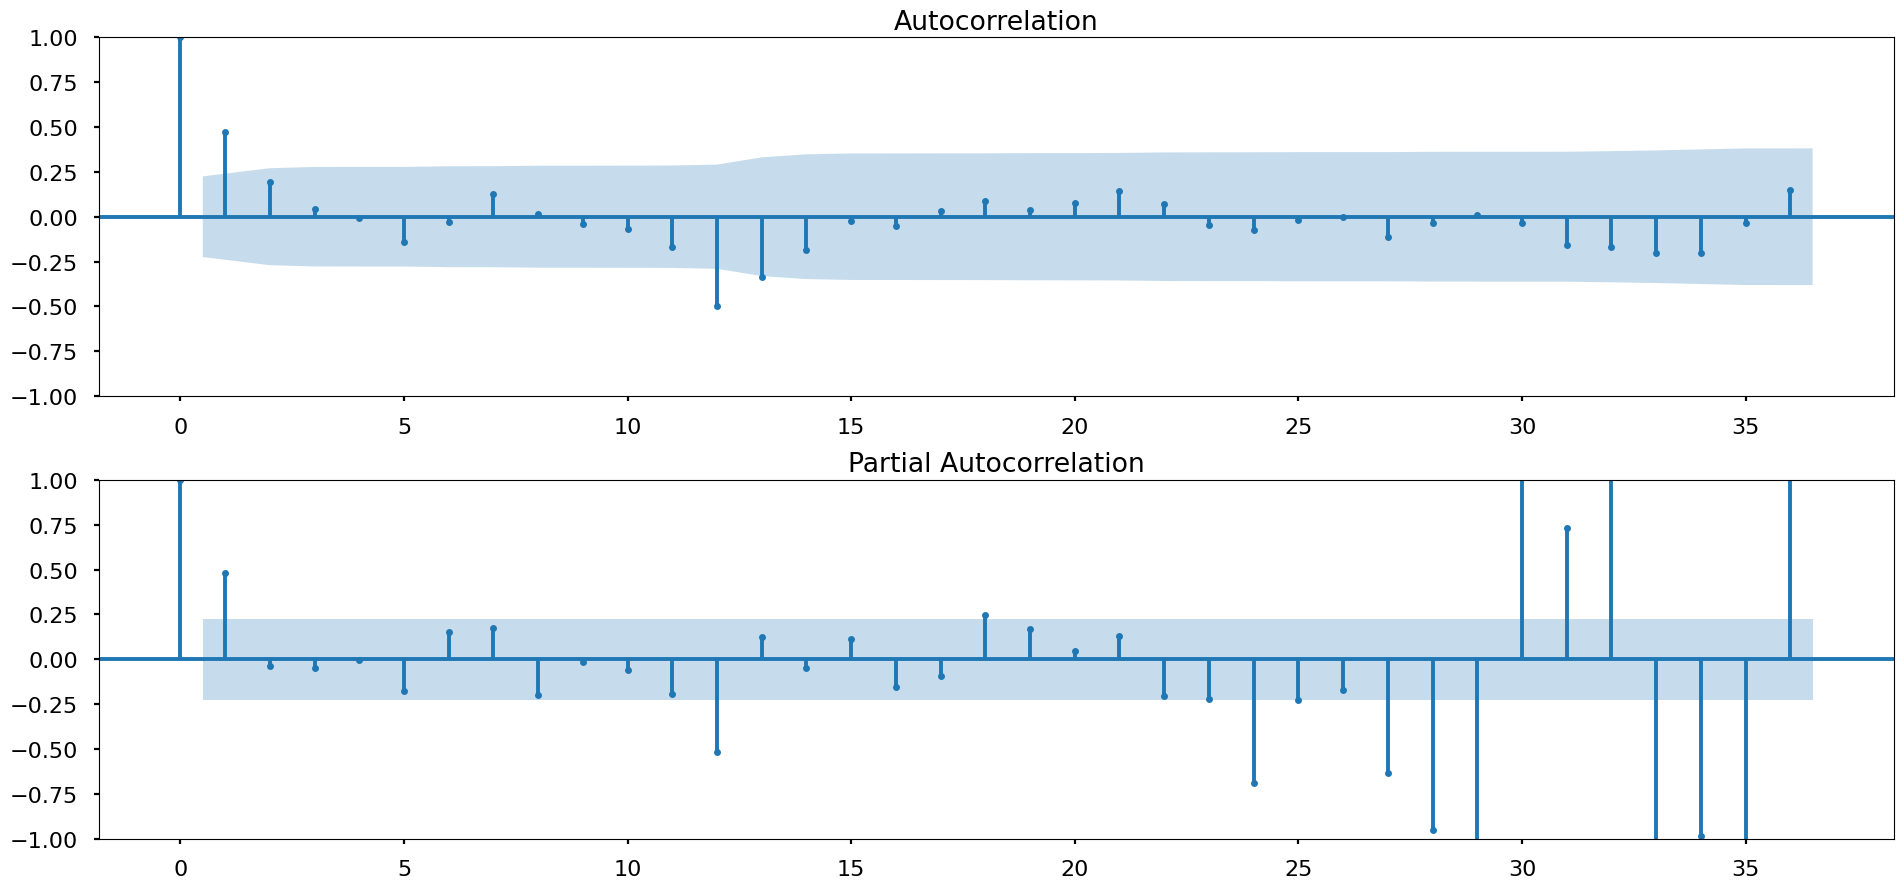

In [31]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(19,9))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=36, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=36, ax=ax)
plt.tight_layout()
plt.show()

In [32]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [34]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  257.367687
22  (1, 0, 2, 0)  258.024118
7   (0, 1, 0, 1)  258.505007
37  (2, 0, 0, 1)  258.906614
13  (0, 2, 0, 1)  258.950875
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   89
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -125.684
Date:                              Sun, 30 Apr 2023   AIC                            257.368
Time:                                      10:43:19   BIC                            264.360
Sample:                                  10-31-2015   HQIC                           260.162
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

## Analysis of residues

Dickey–Fuller test:: p=0.000000


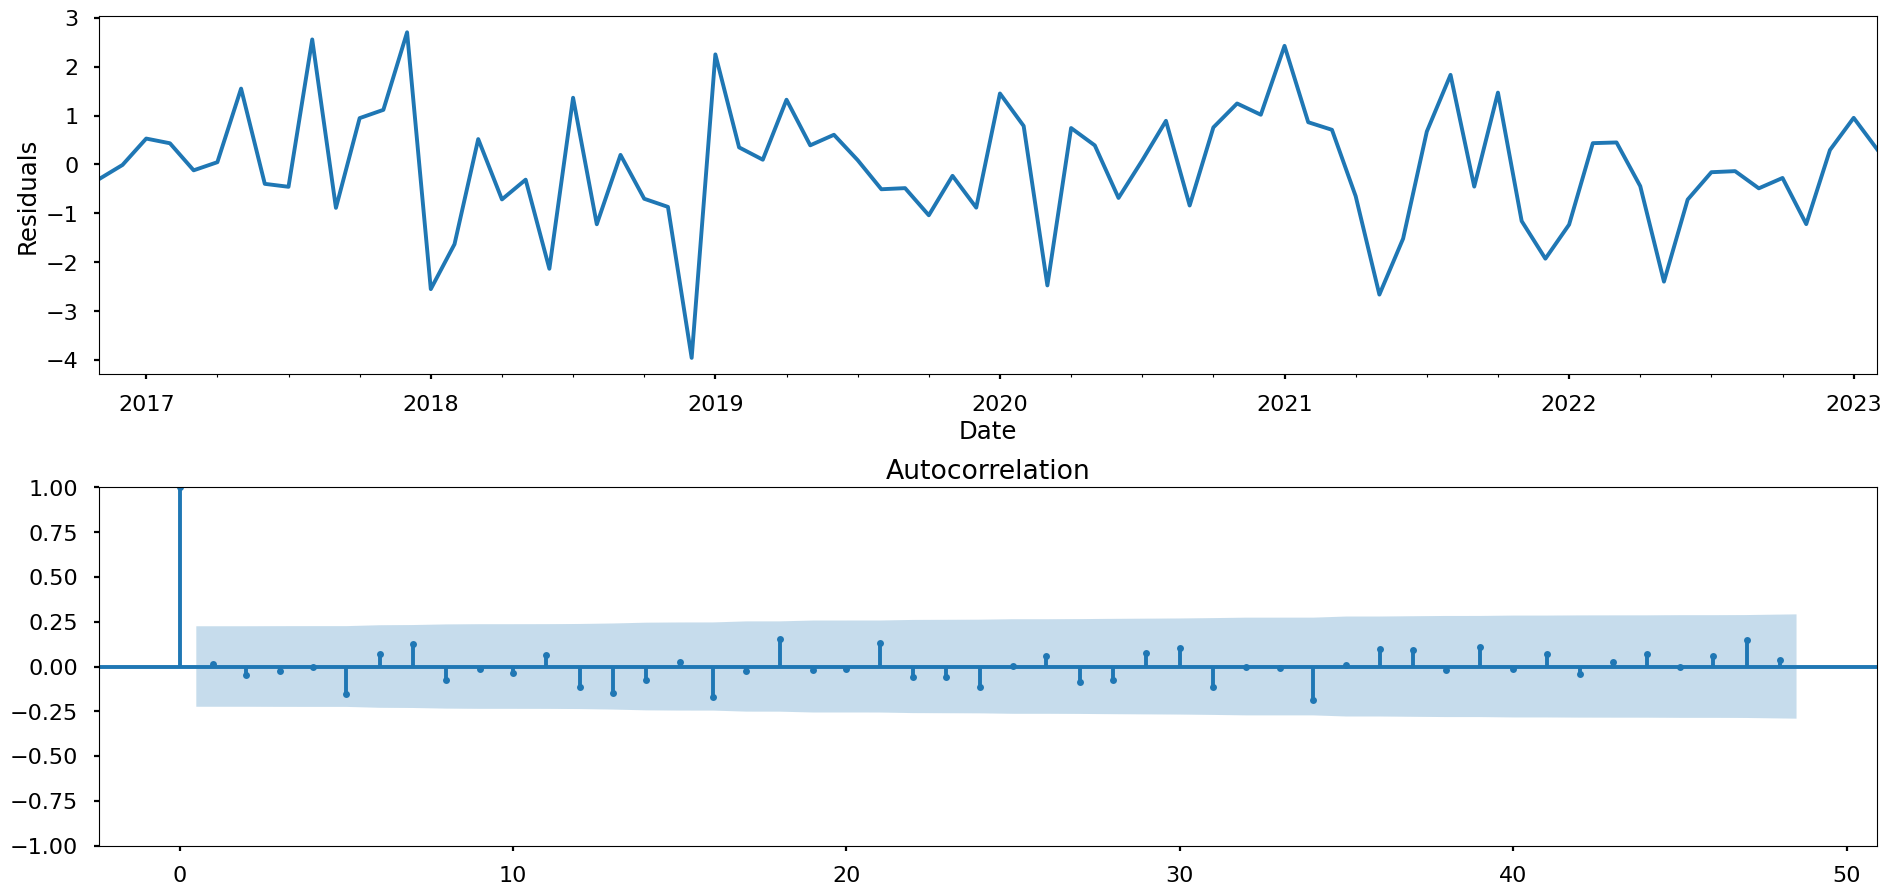

In [35]:
# STL-decomposition
plt.figure(figsize=(19,9))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It`s OK.

## Prediction

In [36]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

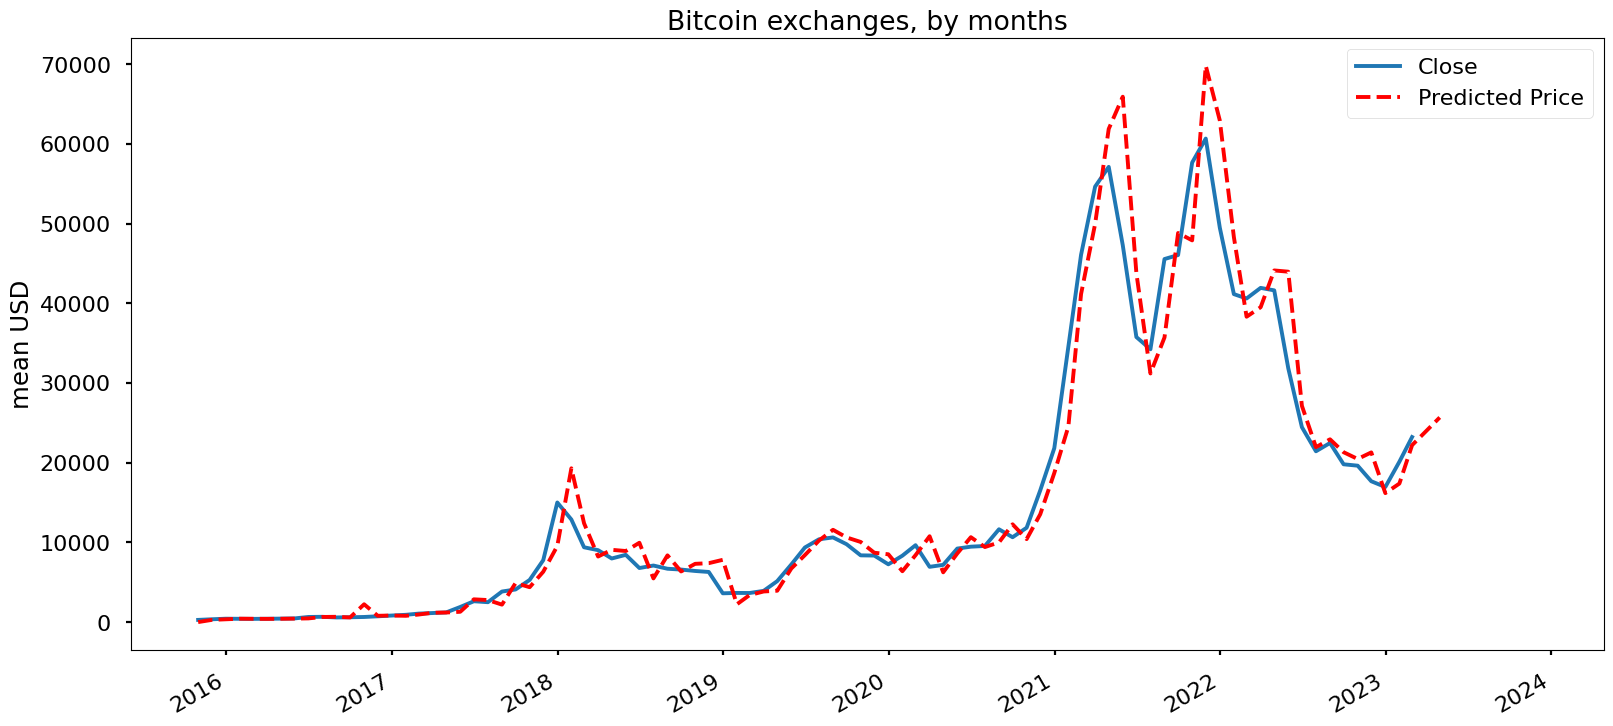

In [44]:
# Prediction
df_month2 = df_month[['Close']]
# date_list = [datetime(2023, 4, 30), datetime(2022, 5, 31), datetime(2022, 6, 30), datetime(2022, 7, 31), 
#              datetime(2022, 8, 31), datetime(2022, 9, 30), datetime(2022, 10, 31), datetime(2022, 11, 30),
#              datetime(2022, 12, 31)]
date_list = [datetime(2023, 4, 30), datetime(2023, 5, 30), datetime(2023, 6, 30), datetime(2023, 7, 30), datetime(2023, 8, 30), datetime(2023, 9, 30), datetime(2023, 10, 30), datetime(2023, 11, 30), datetime(2023, 12, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=130), lmbda)
plt.figure(figsize=(19,9))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()